# 0.0. IMPORTS

In [1]:
import inflection
import math
import datetime
import random
import warnings
import pickle
import json

import numpy               as np
import pandas              as pd
import statistics          as st
import seaborn             as sns
import xgboost             as xgb
import matplotlib.gridspec as gridspec

from boruta     import BorutaPy
from tabulate   import tabulate
from flask      import Flask, request, Response
from matplotlib import pyplot as plt
from scipy      import stats  as ss

from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error

from IPython.display import Image

## 0.1. Helper Functions

In [2]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.absolute( ( y - yhat ) / y ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y)

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error ( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse,}, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k-1 )*( r-1 )/( n-1 ) )
    
    kcorr = k - ( k-1 )**2/( n-1 )
    rcorr = r - ( r-1 )**2/( n-1 )
    
    return np.sqrt( ( chi2corr/n ) / ( min(kcorr-1, rcorr-1) ) )


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKfold Number: {}'.format( k ) )
        
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation), np.expm1( yhat ) )
    
        # store performance of each KFold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype( str ) }, index=[0] )


def descriptive_statistics(data, att_type='num'):
    if att_type =='num':
        # Select numerical attributes
        num_attributes = data.select_dtypes(include=['int64', 'float64'])
        
        # describe numerical attributes
        num_statistics = num_attributes.describe()

        # Calculating Median
        num_statistics.loc['median'] = num_attributes.apply(lambda x: st.median(x))

        # Calculating Mode
        num_statistics.loc['mode'] = num_attributes.apply(lambda x: st.mode(x))

        # Range
        num_statistics.loc['range'] = num_statistics.loc['max'] - num_statistics.loc['min']

        # Calculating skew
        num_statistics.loc['skew'] = num_attributes.skew()

        # Kurtosis
        num_statistics.loc['kurtosis'] = num_attributes.kurtosis()

        # Reorganizing Columns
        num_statistics_final = num_statistics.reindex(['count',
                                                       'mean',
                                                       'median',
                                                       'mode',
                                                       'min',
                                                       '25%',
                                                       '50%',
                                                       '75%',
                                                       'max',
                                                       'range',
                                                       'std',
                                                       'skew',
                                                       'kurtosis']).T
        return num_statistics_final


%matplotlib inline
sns.set(rc={'figure.figsize': (20, 10) } );
warnings.filterwarnings('ignore')


## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv( '~/Repos/Rossmann_Sales_Prediction/Data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '~/Repos/Rossmann_Sales_Prediction/Data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

###  1.7.1 Numerical Attributes

In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

descriptive_statistics(num_attributes)

,count,mean,median,mode,min,25%,50%,75%,max,range,std,skew,kurtosis
store,1017209.00,558.43,558.00,1.00,1.00,280.00,558.00,838.00,1115.00,1114.00,321.91,-0.00,-1.20
day_of_week,1017209.00,4.00,4.00,5.00,1.00,2.00,4.00,6.00,7.00,6.00,2.00,0.00,-1.25
sales,1017209.00,5773.82,5744.00,0.00,0.00,3727.00,5744.00,7856.00,41551.00,41551.00,3849.93,0.64,1.78
customers,1017209.00,633.15,609.00,0.00,0.00,405.00,609.00,837.00,7388.00,7388.00,464.41,1.60,7.09
open,1017209.00,0.83,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.38,-1.76,1.09
promo,1017209.00,0.38,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.49,0.49,-1.76
school_holiday,1017209.00,0.18,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.38,1.68,0.82
competition_distance,1017209.00,5935.44,2330.00,250.00,20.00,710.00,2330.00,6910.00,200000.00,199980.00,12547.65,10.24,147.79
competition_open_since_month,1017209.00,6.79,7.00,9.00,1.00,4.00,7.00,10.00,12.00,11.00,3.31,-0.04,-1.23
competition_open_since_year,1017209.00,2010.32,2012.00,2013.00,1900.00,2008.00,2012.00,2014.00,2015.00,115.00,5.52,-7.24,124.07


Key Points:

- **sales:** mean = 5,773 | max = 41,551 | min = 0 (when store is close)
- **customers:** mean = 633 | max = 7.388 | kutosis = 7.09 | -> big difference between mean an max
- **competition_distance:** mean = 5,415 | median = 2,320 | kurtosis = 13.02
- **competition_open_since_month:** mode = 9 (sept)
- **competition_open_since_year:** mode = 2013 (sept) | min = 1900 | -> The foundation of the company was in 1972.



<AxesSubplot:xlabel='sales', ylabel='Density'>

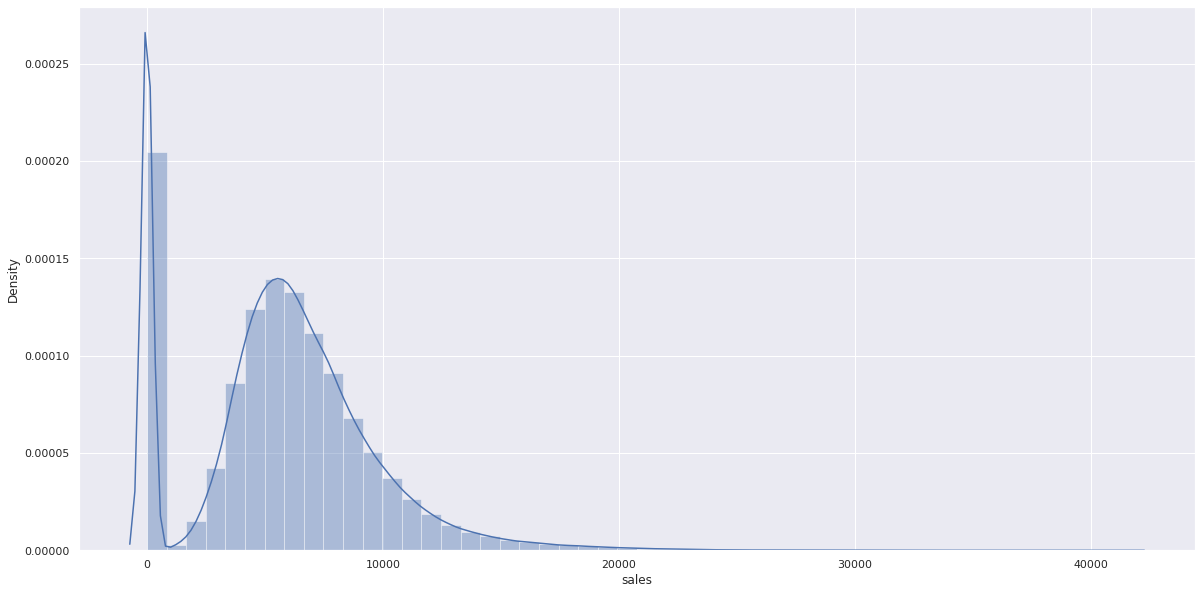

In [14]:
sns.set(rc={'figure.figsize': (20, 10) } )
sns.distplot( df1['sales'] )

### 1.7.2. Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

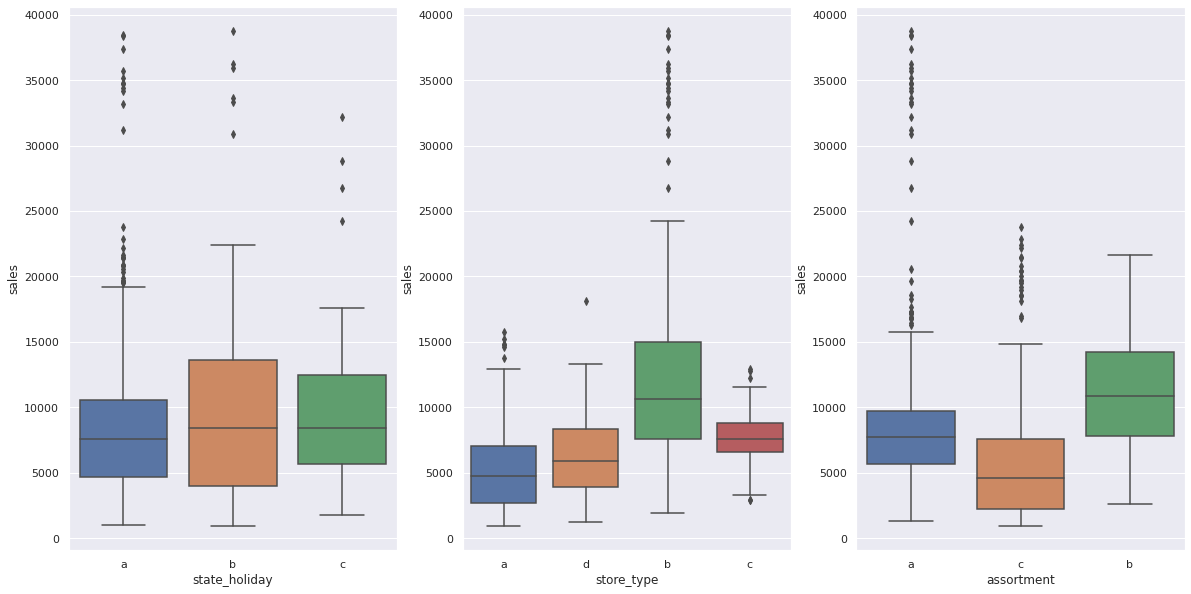

In [16]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.figure( figsize=(20,10) )

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )


**Key Points:**
- **state_holiday:** On public holidays stores sales less in average
- **store_type:** The biggest volume of sales is on store_type 'b'. On the other hand, 'a' store_type has smallest volume of sales
- **assortment:** Stores with 'b' (extra) assortment has bigger volume of sales and 'c' assortment has the smallest volume of sales.

# 2.0. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

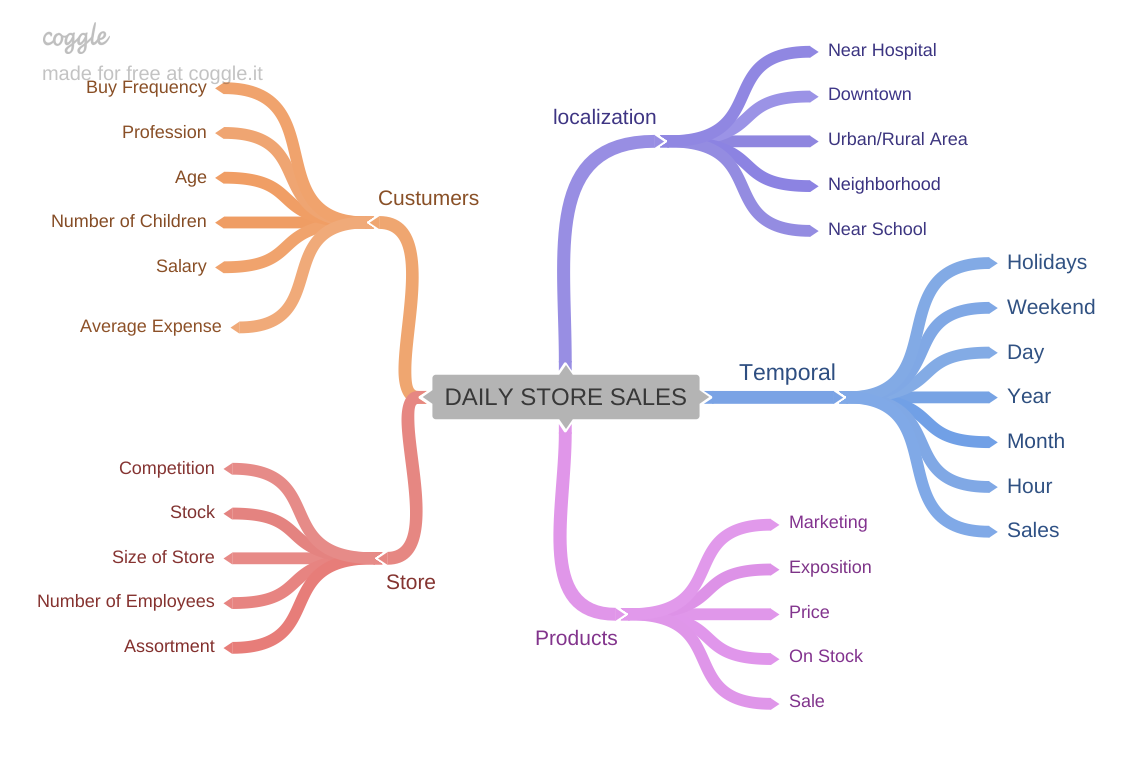

In [18]:
Image('/home/kazu/Repos/Rossmann_Sales_Prediction/img/Mind_Map_Hypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Store with more employees should sell more.

**2.** Stores with larger stock should sell more.

**3.** Larger stores (m2) should sell more.

**4.** Stores with more assortment should sell more.

**5.** Stores with near competitors should sell less.

**6.** Stores with older competitores should sell more.


### 2.2.2. Product Hypothesis

**1.** Stores that invests more on marketing should sell more.

**2.** Stores with larger showcase should sell more.

**3.** Stores with cheaper products should sell more.

**5.** Stores with more agressive promo (bigger discounts), should sell more.

**6.** Stores with longer active promo should sell more.

**7.** Stores with more promo days should sell more.

**8.** Stores with more consecutives promo should sell more

### 2.2.3. Temporal Hypothesis

**1.** Stores that opens during christmas should sell more

**2.** Stores should sell more through the years. (older stores)

**3.** Stores should sell more in the second semester.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less on school holidays.

## 2.3. Final Hypothesis List

**1.** Stores with more assortment should sell more.

**2.** Stores with near competitors should sell less.

**3.** Stores with older competitores should sell more.

**4.** Stores with longer active promo should sell more.

**5.** Stores with more promo days should sell more.

**6.** Stores with more consecutives promo should sell more

**7.** Stores that opens during christmas should sell more

**8.** Stores should sell more through the years.

**9.** Stores should sell more in the second semester.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less on school holidays.


## 2.4. Feature Engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

In [20]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. VARIABLE FILTRATION

In [21]:
df3 = df2.copy()

## 3.1. Rows Filter

In [22]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2. Columns Selection

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. EXPLORATORY DATA ANALYSIS

In [24]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

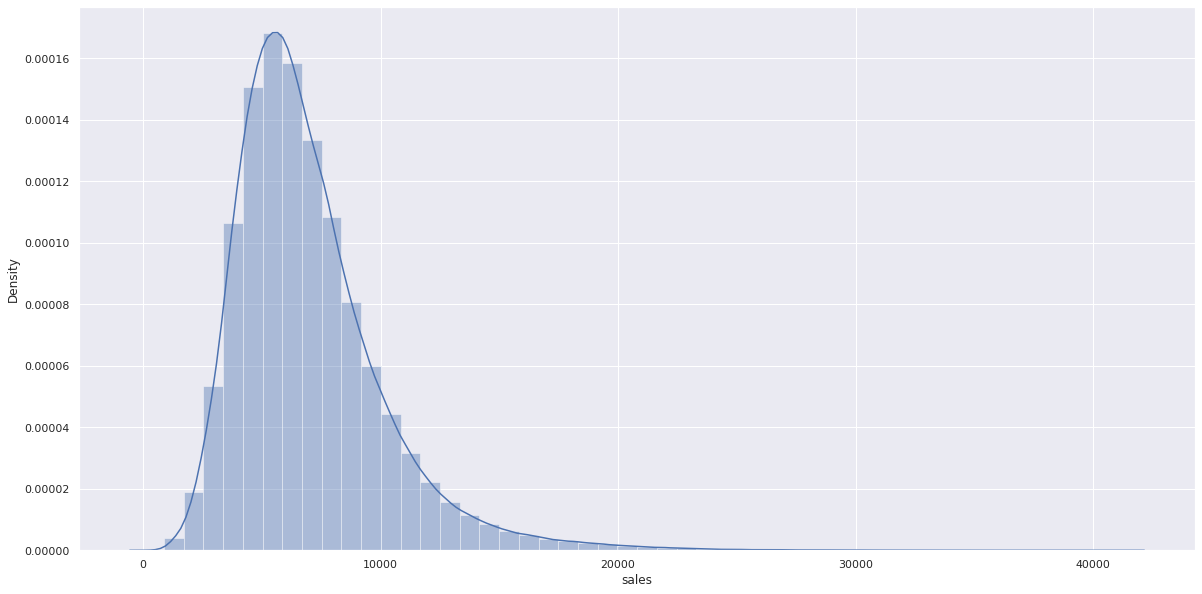

In [25]:
sns.distplot( df4['sales'] )

### 4.1.2. Numerical Variable

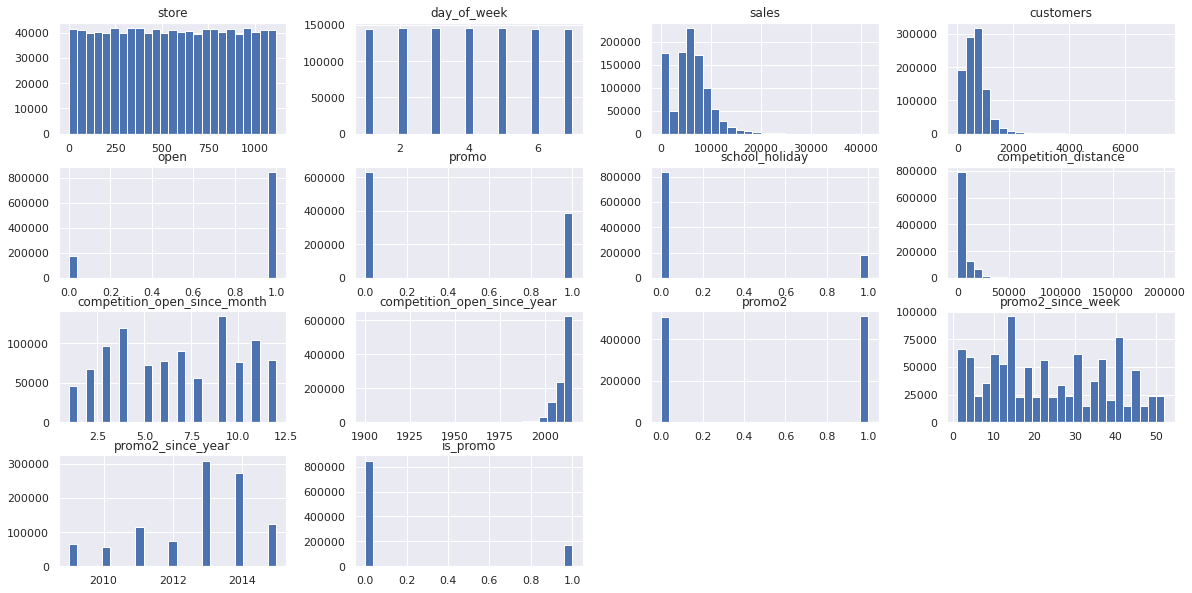

In [26]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [27]:
cat_attributes.head()
df4['state_holiday'].drop_duplicates()

0            regular day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

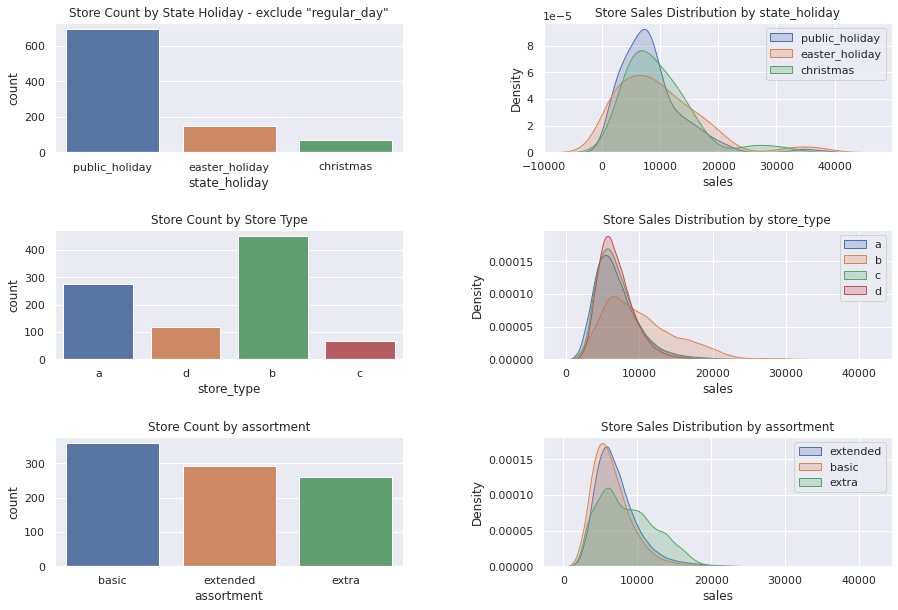

In [28]:
plt.figure(figsize=(15,10))

# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular day']
sns.countplot( a['state_holiday'] ).set_title('Store Count by State Holiday - exclude "regular_day"')

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True ).set_title('Store Sales Distribution by state_holiday')
plt.legend()

# store_type
plt.subplot( 3, 2, 3)
sns.countplot( a['store_type'] ).set_title('Store Count by Store Type') 

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',shade=True ).set_title('Store Sales Distribution by store_type')
plt.legend()


# assortment
plt.subplot( 3, 2, 5)
sns.countplot( a['assortment'] ).set_title('Store Count by assortment')

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True ).set_title('Store Sales Distribution by assortment')
plt.legend()

plt.subplots_adjust(hspace = 0.6)
plt.subplots_adjust(wspace = 0.4)

## 4.2. Bivariate Analysis

### H1. Stores with bigger assortments should sell more.
**TRUE** Stores with extra assortment type in average sell more. But in regard of absolute sales volume, basic assortment type sells more.

**Key Points**
- Stores with Extra assortment in average sell more than other types of assortments;
- In regard of total sales, basic assortment type sells the most absolute volume due to be the most common assortment type;
- We can observe that around week 50 of each year there are big decrease in sales.

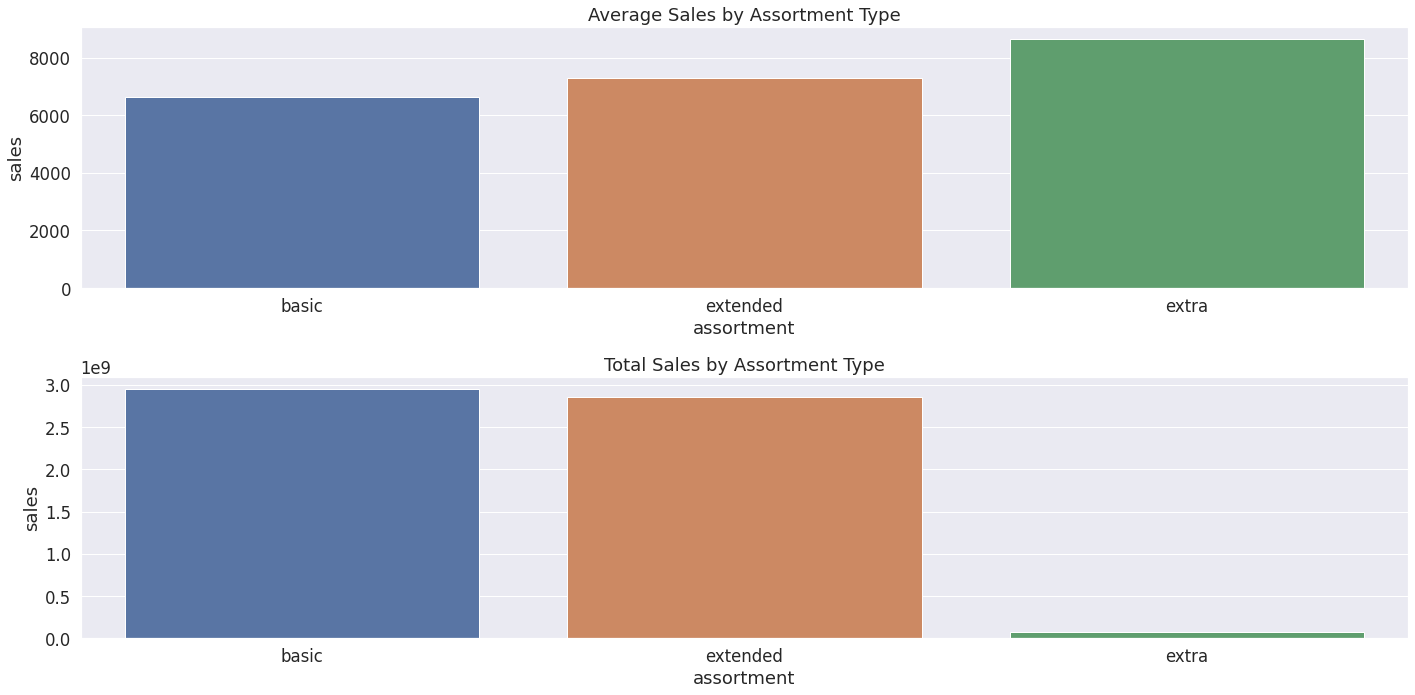

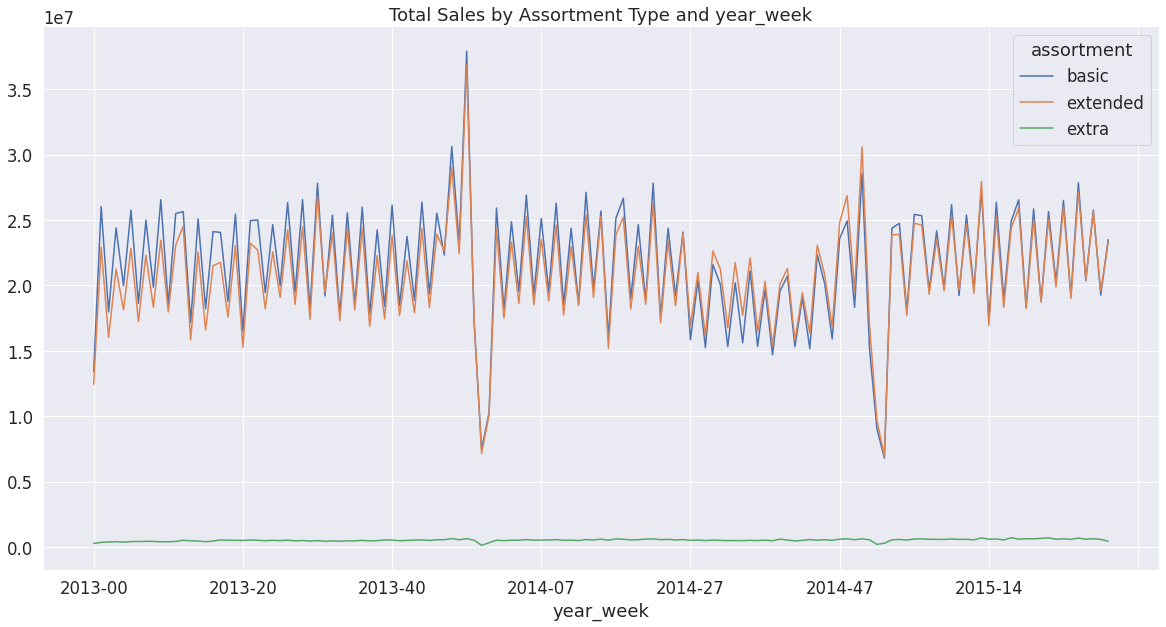

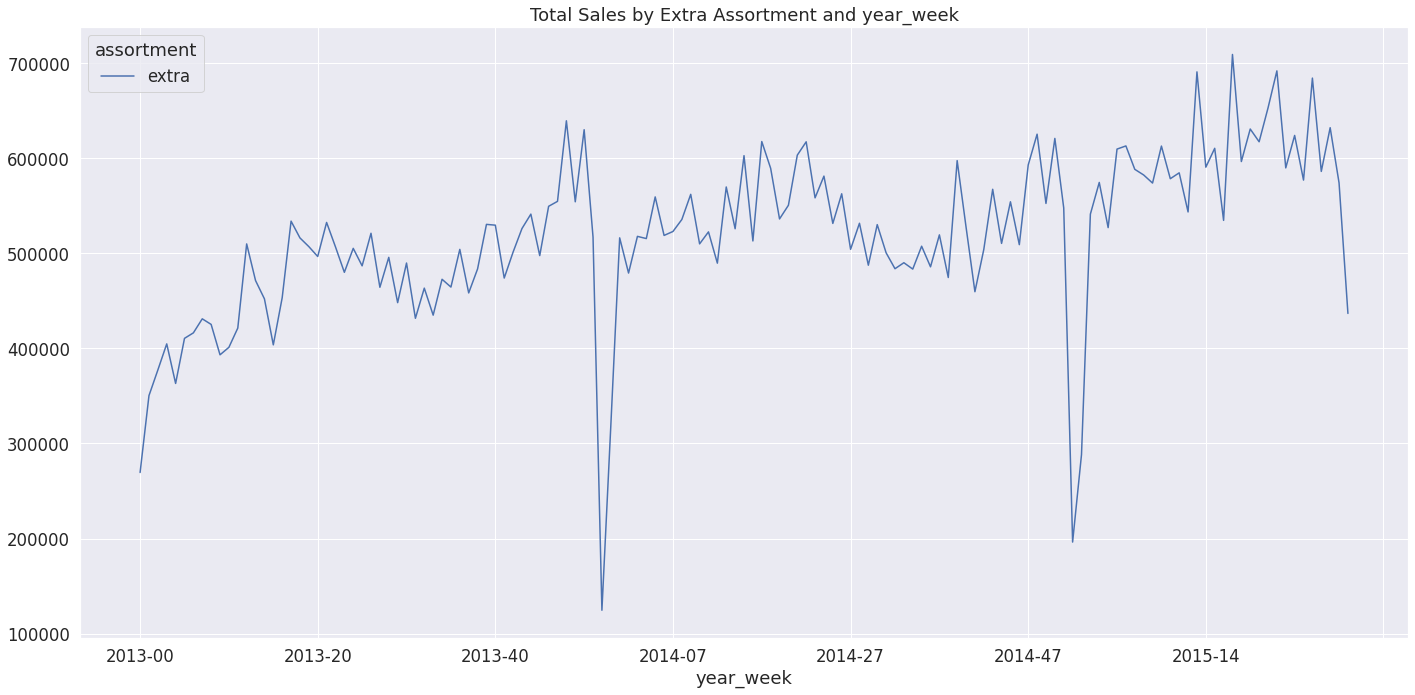

In [29]:
aux1_1 = df4[['sales', 'assortment']].groupby('assortment').mean().reset_index()
aux1_2 = df4[['sales', 'assortment']].groupby('assortment').sum().reset_index()
aux1_3 = df4[['sales', 'assortment', 'year_week']].groupby(['assortment', 'year_week']).sum().reset_index()
aux1_4 = aux1_3[aux1_3['assortment'] == 'extra']

sns.set(font_scale=1.5)

# Ploting the average sales by assortment type
plt.subplot(2, 1, 1)
sns.barplot(x='assortment', y='sales', data=aux1_1).set_title('Average Sales by Assortment Type', fontsize=18);

# Ploting the absolute sales by assortment type
plt.subplot(2, 1, 2)
sns.barplot(x='assortment', y='sales', data=aux1_2).set_title('Total Sales by Assortment Type', fontsize=18);

plt.tight_layout();

# Ploting the absolute sales by assortment type and year_week
aux1_3.pivot(index='year_week', columns='assortment', values='sales').plot().set_title('Total Sales by Assortment Type and year_week', fontsize=18);

# Ploting the absolute sales by assortment type and through Time
aux1_4.pivot(index='year_week', columns='assortment', values='sales').plot().set_title('Total Sales by Extra Assortment and year_week', fontsize=18);

plt.tight_layout();

### H2. Stores with near competitors should sell less.
**FALSE** Stores with near competitors sell more.

**Key Points:**
- Stores with near competitiors sell more in average and in total volume;

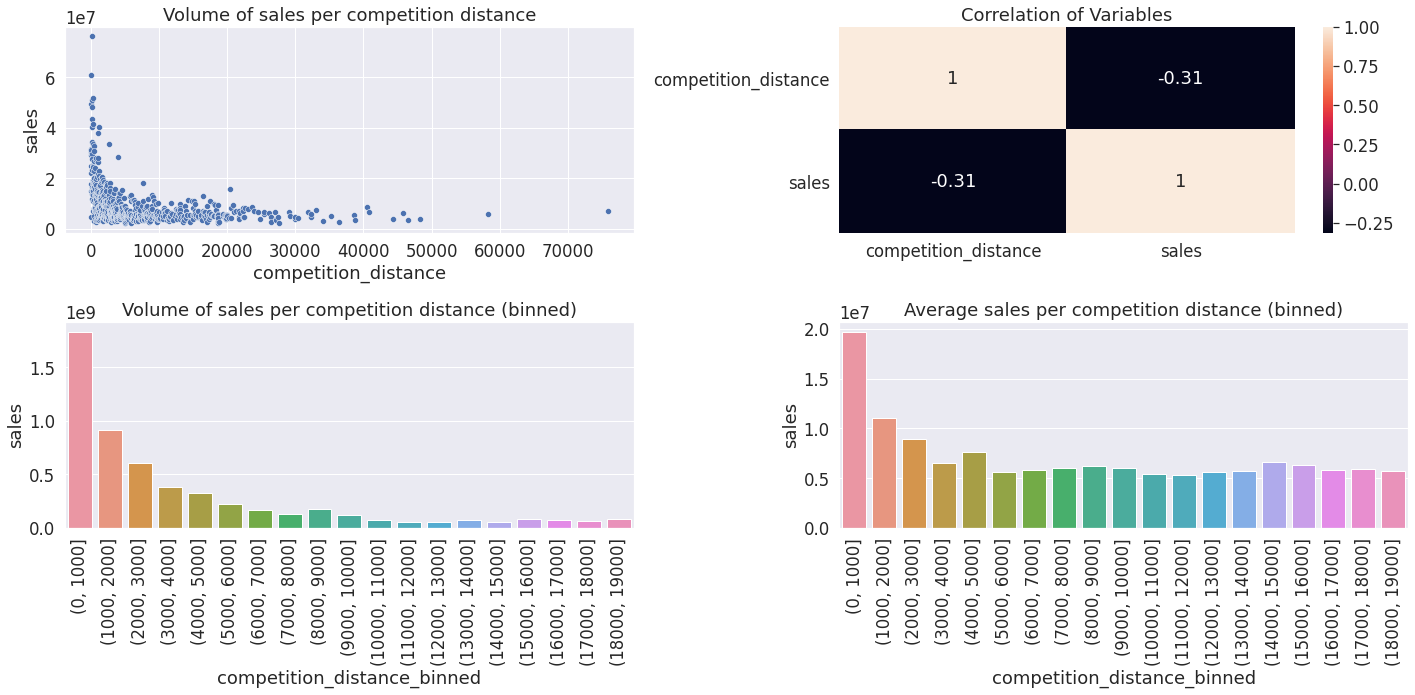

In [30]:
# Selecting competition_distance < 199999
aux1 = df4[df4['competition_distance']<199999]

# Scatterplot
aux2_1 = aux1[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(2, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux2_1).set_title('Volume of sales per competition distance');

# Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(aux2_1.corr(method='pearson'), annot=True).set_title('Correlation of Variables');

# Barplot absolute sales with Bins
bins = list(np.arange(0, 20000, 1000))
aux2_1['competition_distance_binned'] = pd.cut(aux2_1['competition_distance'], bins=bins)
aux2_2 = aux2_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(2, 2, 3)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2_2).set_title('Volume of sales per competition distance (binned)');
plt.xticks(rotation=90);

# Barplot average sales with Bins
aux2_3 = aux2_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2_3).set_title('Average sales per competition distance (binned)');
plt.xticks(rotation=90);

plt.tight_layout();

### H3. Stores with competitors for more time should sell more.
**FALSE** Stores that has recent competitors sells more.

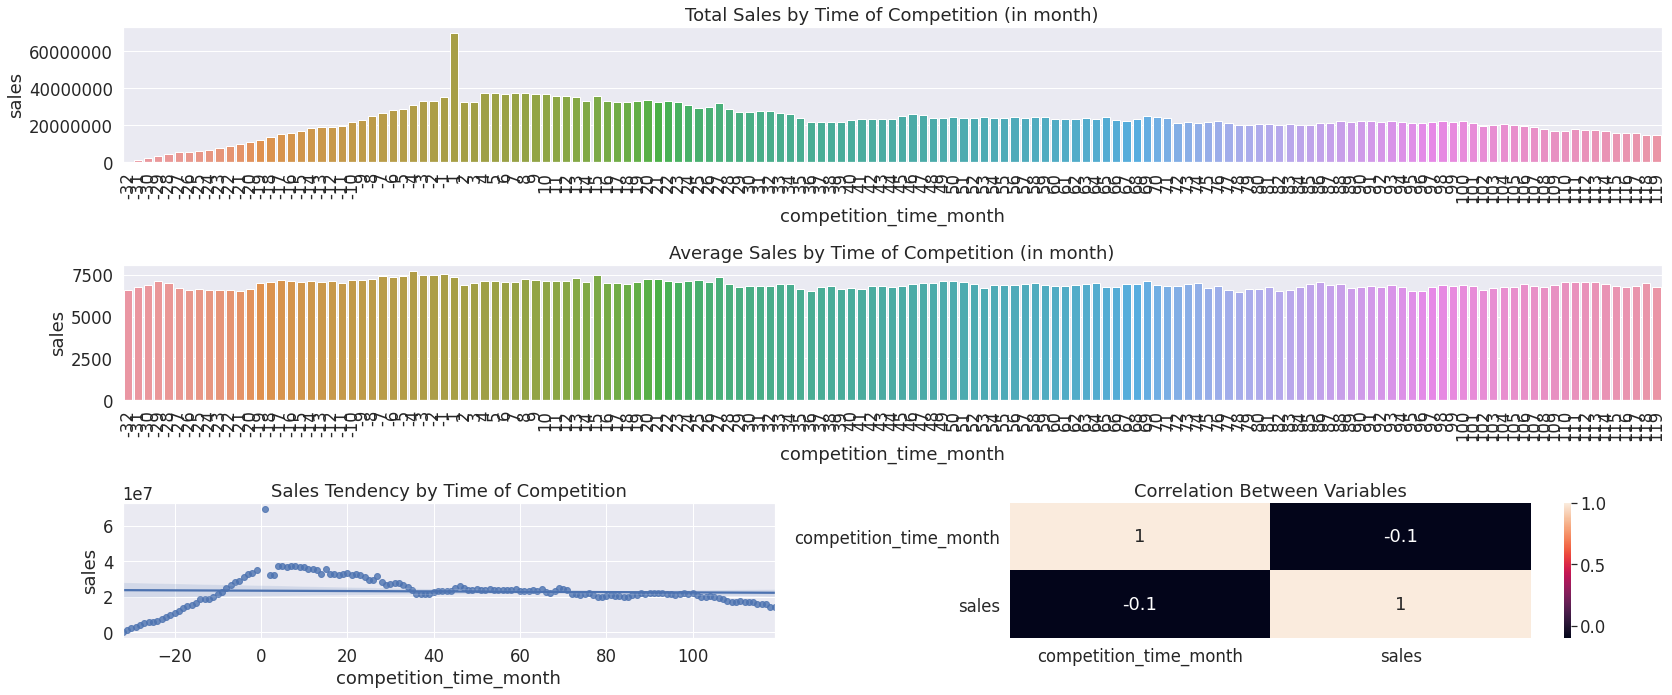

In [31]:
aux3_1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux3_2 = aux3_1[(aux3_1['competition_time_month']<120) & (aux3_1['competition_time_month'] != 0)]
aux3_3 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux3_4 = aux3_3[(aux3_3['competition_time_month']<120) & (aux3_3['competition_time_month'] != 0)]

grid = gridspec.GridSpec(3, 2)
plt.figure(figsize=(23, 10));

plt.subplot(grid[0, :])
sns.barplot(x='competition_time_month', y='sales', data=aux3_2).set_title('Total Sales by Time of Competition (in month)');
plt.xticks(rotation=90);

plt.subplot(grid[1, :])
sns.barplot(x='competition_time_month', y='sales', data=aux3_4).set_title('Average Sales by Time of Competition (in month)');
plt.xticks(rotation=90);

plt.subplot(grid[2,0])
sns.regplot(x='competition_time_month', y='sales', data=aux3_2).set_title('Sales Tendency by Time of Competition')

plt.subplot(grid[2,1])
sns.heatmap(aux3_1.corr(method='pearson'), annot=True).set_title('Correlation Between Variables')

plt.tight_layout()
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)



### H4. Stores with longer active promo should sell more.

**FALSE** Stores with longer active promo sell less, after certain period of time

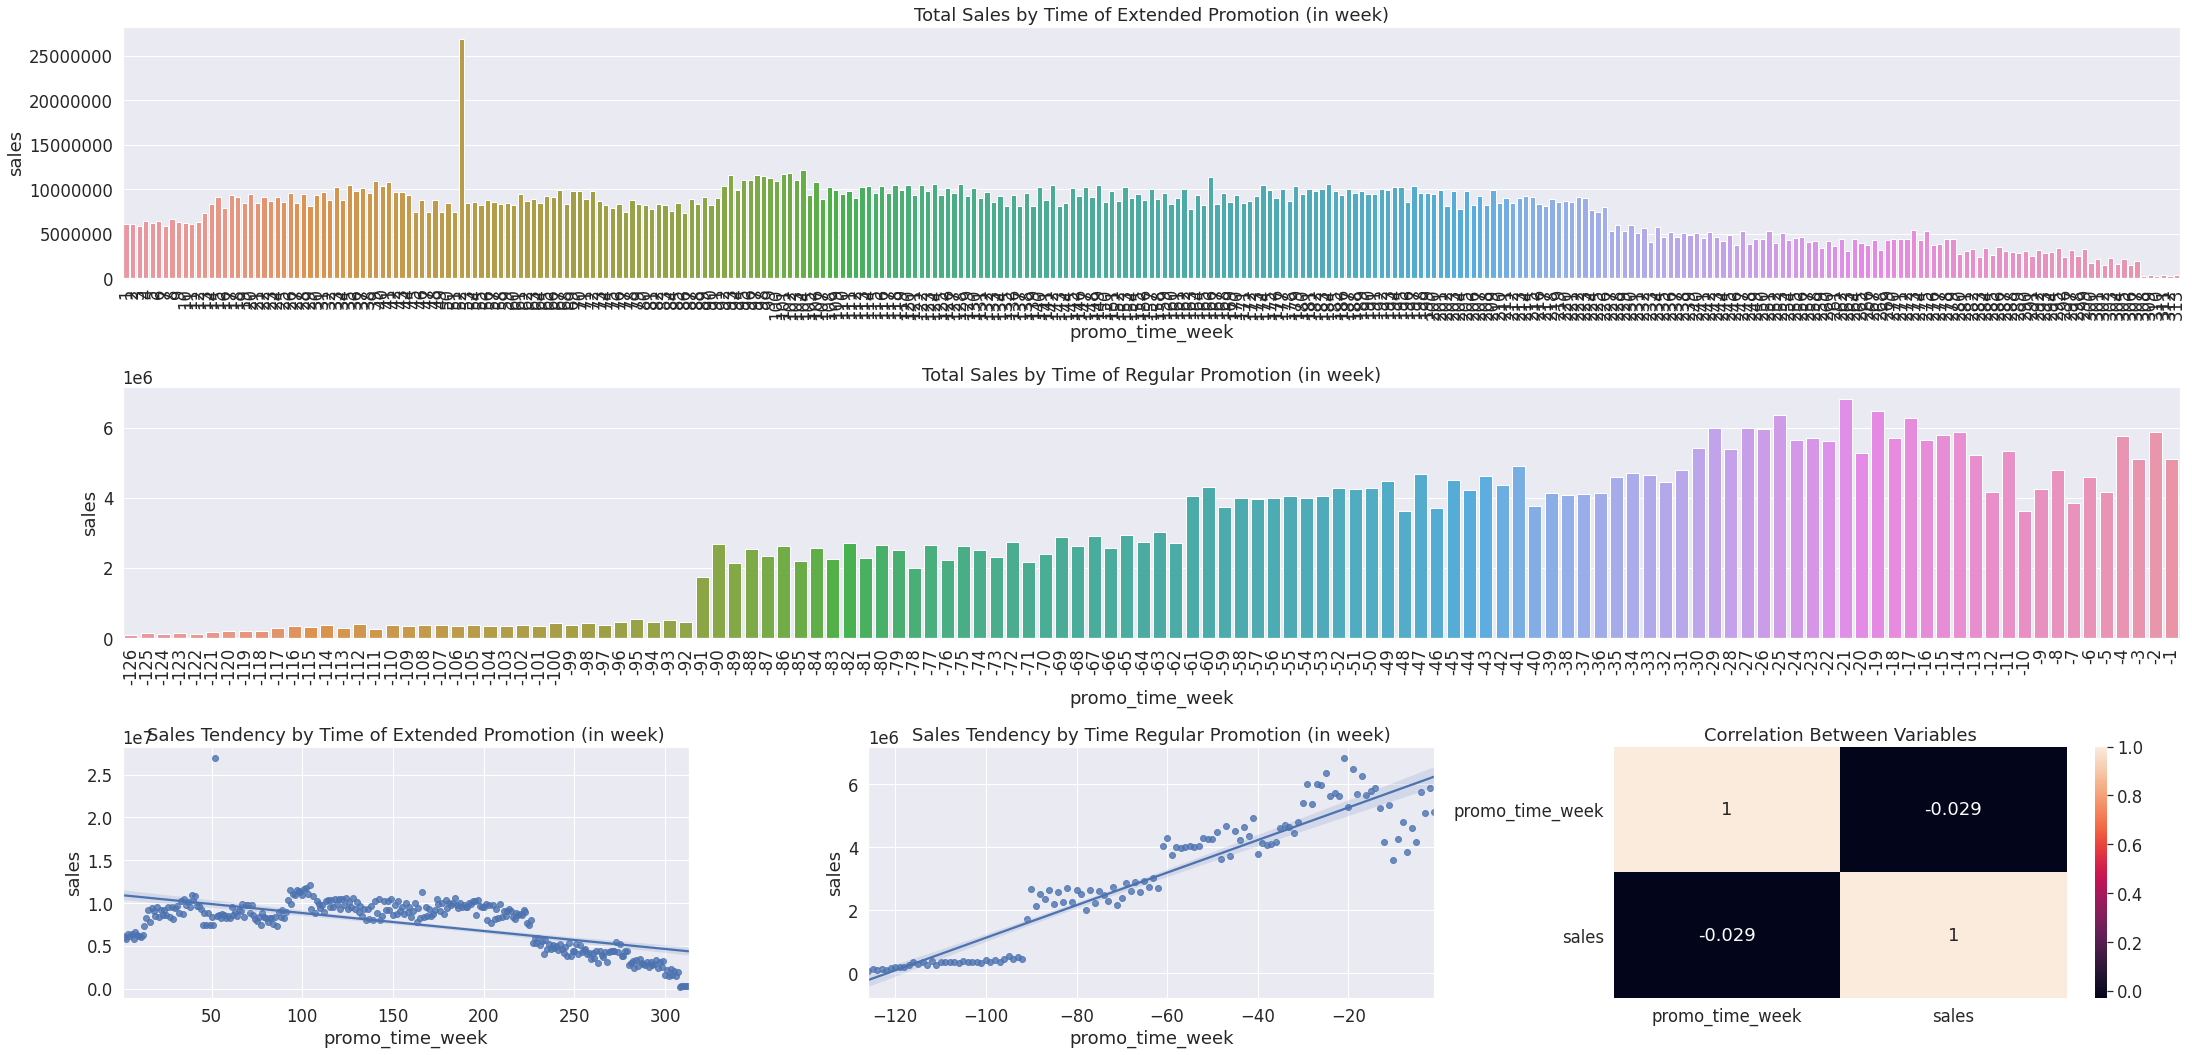

In [32]:
aux4_1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(3, 3)
plt.figure(figsize=(30, 15))

plt.subplot(grid[0, :])
aux4_2 =aux4_1[aux4_1['promo_time_week']>0] # Promo Extended
sns.barplot(x='promo_time_week', y='sales', data=aux4_2).set_title('Total Sales by Time of Extended Promotion (in week)');
plt.xticks(rotation=90);

plt.subplot(grid[1, :])
aux4_3 = aux4_1[aux4_1['promo_time_week']<0] # Regular Promo
sns.barplot(x='promo_time_week', y='sales', data=aux4_3).set_title('Total Sales by Time of Regular Promotion (in week)')
plt.xticks(rotation=90);

plt.subplot(grid[2, 0])
sns.regplot(x='promo_time_week', y='sales', data=aux4_2).set_title('Sales Tendency by Time of Extended Promotion (in week)')

plt.subplot(grid[2, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux4_3).set_title('Sales Tendency by Time Regular Promotion (in week)')

plt.subplot(grid[2, 2])
sns.heatmap(aux4_1.corr(method='pearson'), annot=True).set_title('Correlation Between Variables')

plt.tight_layout()
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

### <s>H5. Stores with more promo days should sell more.</s>

### H6. Stores with more consecutives promo should sell more
**FALSE** Stores with extended promo sell less.

In [33]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


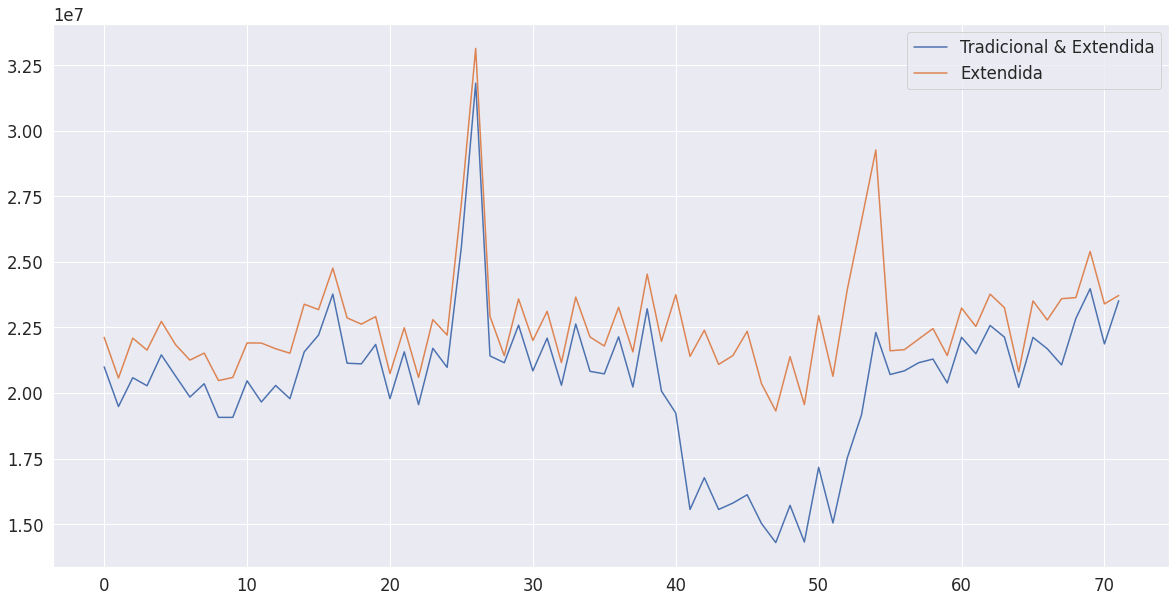

In [34]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida'] );


### H7. Stores that opens during christmas should sell more 
**FALSE** The holiday that sales more in average is Easter

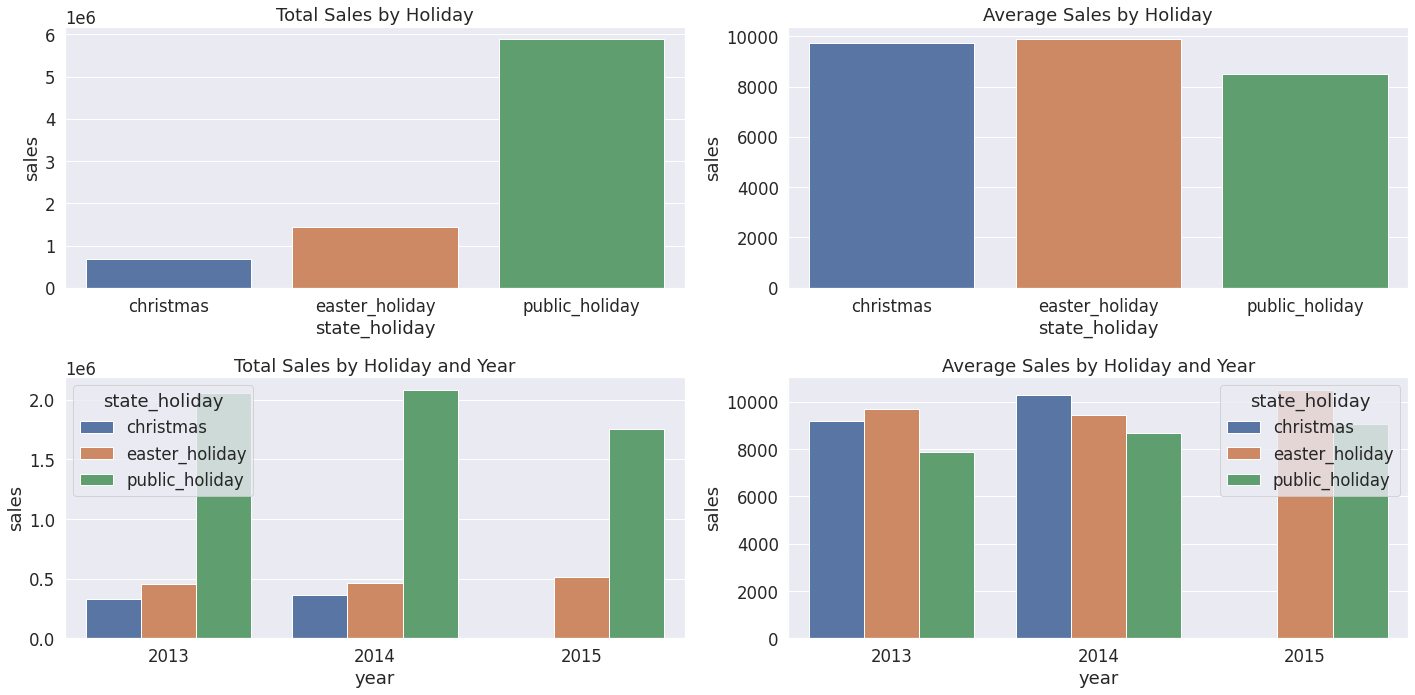

In [35]:
aux7_1 = df4[df4['state_holiday'] != 'regular day']

plt.subplot(2, 2, 1)
aux7_2 = aux7_1[['state_holiday', 'sales']].groupby( 'state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux7_2 ).set_title('Total Sales by Holiday');

plt.subplot(2, 2, 2)
aux7_3 = aux7_1[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux7_3).set_title('Average Sales by Holiday');

plt.subplot(2, 2, 3)
aux7_4 = aux7_1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux7_4).set_title('Total Sales by Holiday and Year');

plt.subplot(2, 2, 4)
aux7_5 = aux7_1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux7_5).set_title('Average Sales by Holiday and Year');

plt.tight_layout()

### H8. Stores should sell more through the years.
**FALSE** Stores sell less through the years.

**Obs:** The most recent data that we have is untill 31/07/2015, so data of 2015 is incomplete

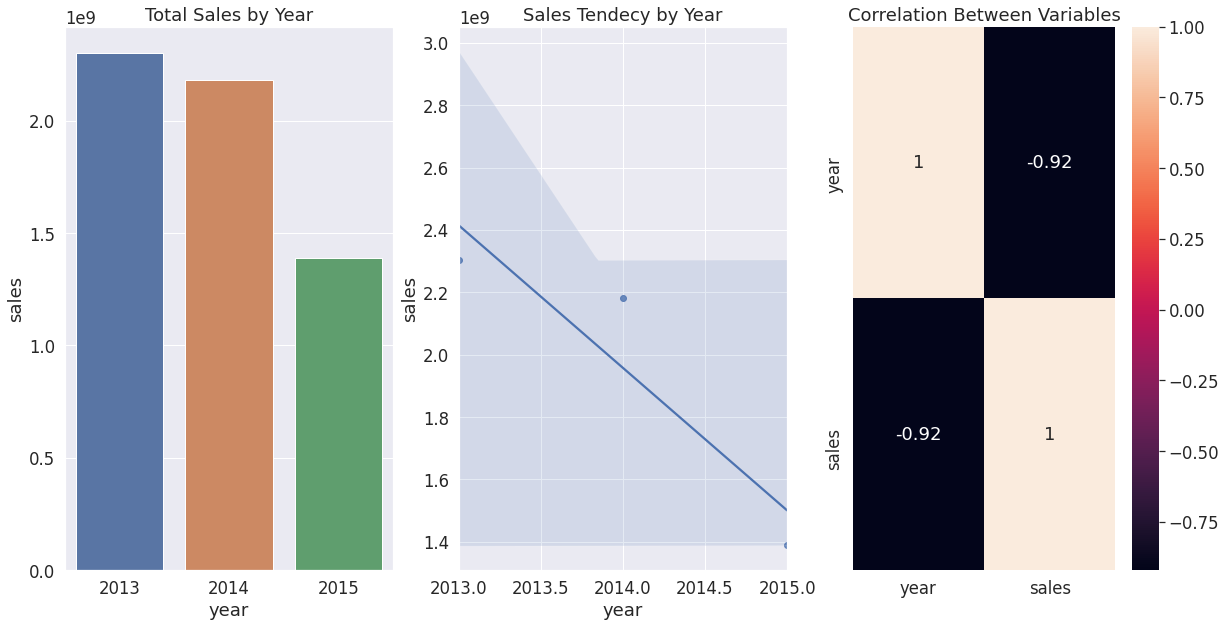

In [36]:
aux9_1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux9_1).set_title('Total Sales by Year');

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux9_1).set_title('Sales Tendecy by Year');

plt.subplot(1, 3, 3)
sns.heatmap(aux9_1.corr(method='pearson'), annot=True).set_title('Correlation Between Variables');

### H9. Stores should sell more in the second semester.
**TRUE** Stores sell more in the second semester.

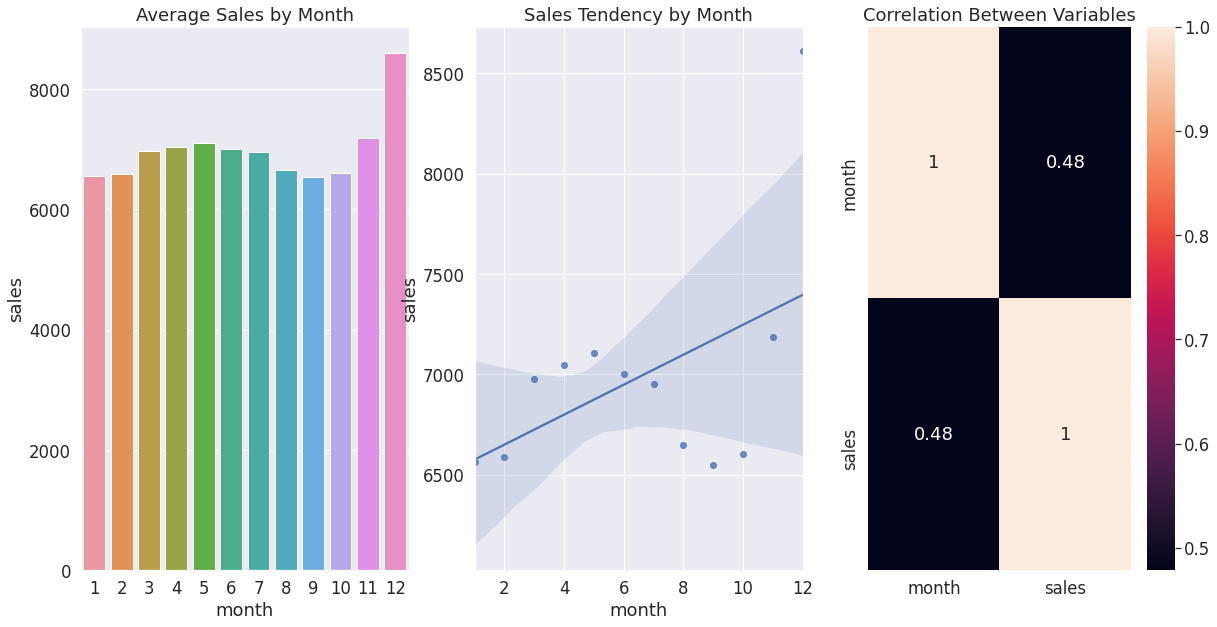

In [37]:
aux9_1 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux9_1).set_title('Average Sales by Month');

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux9_1).set_title('Sales Tendency by Month');

plt.subplot(1, 3, 3)
sns.heatmap(aux9_1.corr(method='pearson'), annot=True).set_title('Correlation Between Variables');

### H10. Stores should sell more after the 10th day of each month.
**FALSE** After the 10th of the month stores sell less

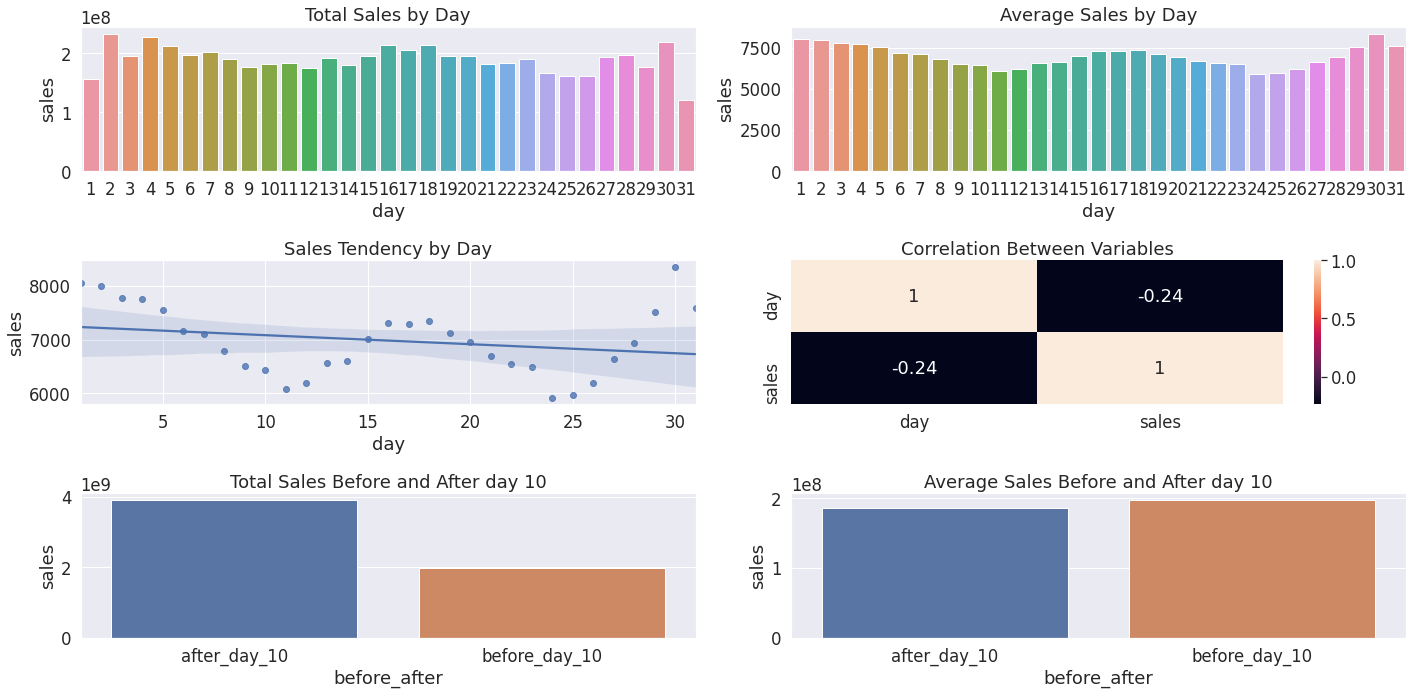

In [38]:
aux10_1 = df4[['sales', 'day']].groupby('day').sum().reset_index()
aux10_2 = df4[['sales', 'day']].groupby('day').mean().reset_index()
aux10_1['before_after'] = aux10_1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux10_3 = aux10_1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
aux10_4 = aux10_1[['before_after', 'sales']].groupby('before_after').mean().reset_index()

plt.subplot(3, 2, 1)
sns.barplot(x='day', y='sales', data=aux10_1).set_title('Total Sales by Day');

plt.subplot(3, 2, 2)
sns.barplot(x='day', y='sales', data=aux10_2).set_title('Average Sales by Day');

plt.subplot(3, 2, 3)
sns.regplot(x='day', y='sales', data=aux10_2).set_title('Sales Tendency by Day');

plt.subplot(3, 2, 4)
sns.heatmap(aux10_2.corr(method='pearson'), annot=True).set_title('Correlation Between Variables');

plt.subplot(3, 2, 5)
sns.barplot(x='before_after', y='sales', data=aux10_3).set_title('Total Sales Before and After day 10');

plt.subplot(3, 2, 6)
sns.barplot(x='before_after', y='sales', data=aux10_4).set_title('Average Sales Before and After day 10');

plt.tight_layout()

### H11. Stores should sell less on weekends.
**PARTIALLY TRUE** On Saturnday stores sell less but on sundays stores sell more

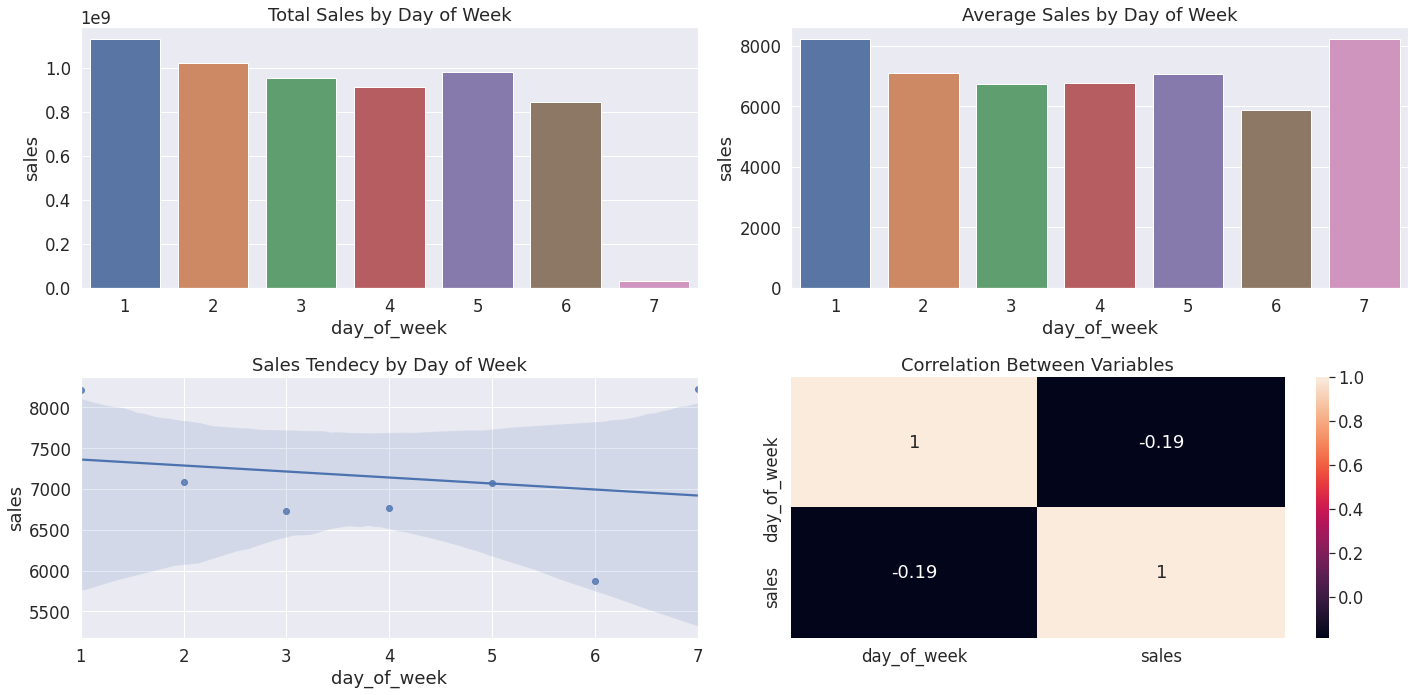

In [39]:
aux11_1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
aux11_2 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day_of_week', y='sales', data=aux11_1).set_title('Total Sales by Day of Week');

plt.subplot(2, 2, 2)
sns.barplot(x='day_of_week', y='sales', data=aux11_2).set_title('Average Sales by Day of Week');

plt.subplot(2, 2, 3)
sns.regplot(x='day_of_week', y='sales', data=aux11_2).set_title('Sales Tendecy by Day of Week');

plt.subplot(2, 2, 4)
sns.heatmap(aux11_2.corr(method='pearson'), annot=True).set_title('Correlation Between Variables');

plt.tight_layout()

### H12. Stores should sell less on school holidays.
**FALSE** Stores sell more on school holidays

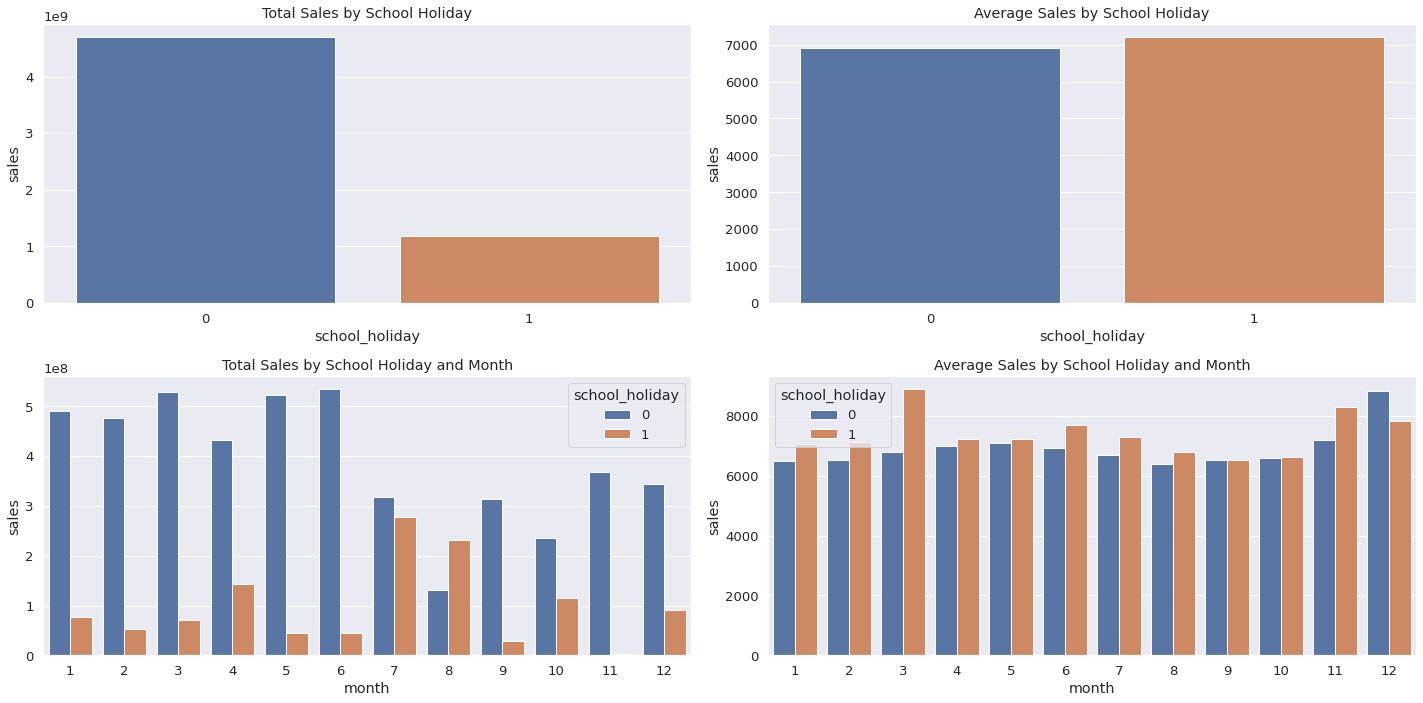

In [86]:
aux12_1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux12_2 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
aux12_3 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
aux12_4 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()


plt.subplot(2, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux12_1).set_title('Total Sales by School Holiday');

plt.subplot(2, 2, 2)
sns.barplot(x='school_holiday', y='sales', data=aux12_2).set_title('Average Sales by School Holiday');

plt.subplot(2, 2, 3)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux12_3).set_title('Total Sales by School Holiday and Month');

plt.subplot(2, 2, 4)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux12_4).set_title('Average Sales by School Holiday and Month');

plt.tight_layout()

### 4.2.1. Hypothesis Summary

In [41]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'True', 'High'],
       ['H10', 'False', 'High'],
       ['H11', 'Partially True', 'High'],
       ['H12', 'False', 'Low'],
      ]
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion      Relevance
------------  --------------  -----------
H1            True            Low
H2            False           Medium
H3            False           Medium
H4            False           Low
H5            -               -
H6            False           Low
H7            False           Medium
H8            False           High
H9            True            High
H10           False           High
H11           Partially True  High
H12           False           Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

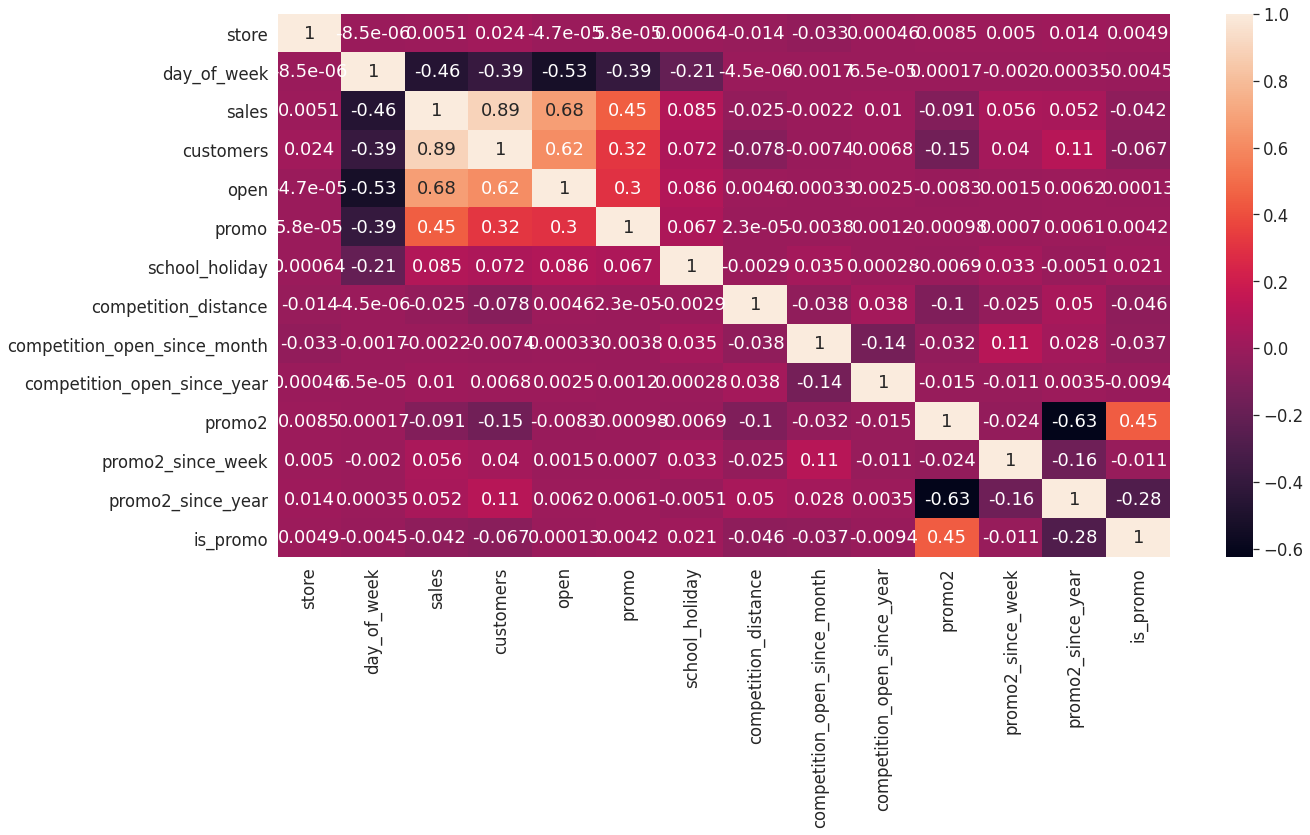

In [42]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True)
sns.set(font_scale=1.2)


### 4.3.2. Categorical Attributes

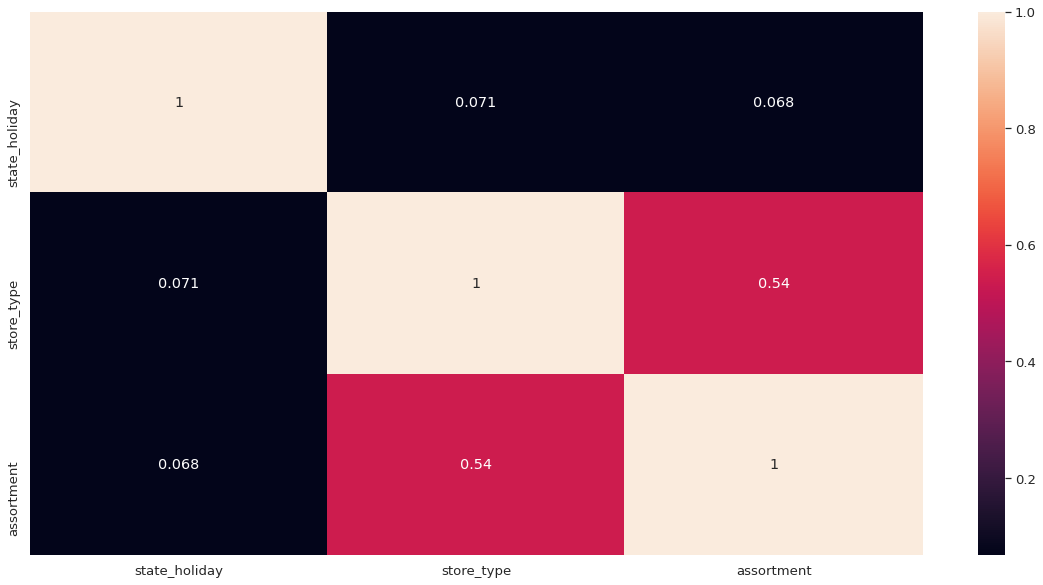

In [43]:
# only categorical attributes
a = df4.select_dtypes( include='object' )

# Calculate cramer_v
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] } )

d = d.set_index( d.columns )
sns.heatmap( d, annot=True ) ;

# 5.0. DATA PREPARATION

In [44]:
df5 = df4.copy()

## 5.1. Normalization
Not applied

## 5.2. Rescaling

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/home/kazu/Repos/Rossmann_Sales_Prediction/parameter/competition_distance_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/home/kazu/Repos/Rossmann_Sales_Prediction/parameter/year_scaler.pkl', 'wb') )

# competitions_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( '/home/kazu/Repos/Rossmann_Sales_Prediction/parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values ) 
pickle.dump( rs, open( '/home/kazu/Repos/Rossmann_Sales_Prediction/parameter/promo_time_week_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [46]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular day,1,c,basic,-0.17,...,0,1.00,7,31,31,2015-30,2008-09-01,0.92,2015-07-27,0.29
1,2,5,2015-07-31,6064,1,regular day,1,a,basic,-0.28,...,1,1.00,7,31,31,2015-30,2007-11-01,1.05,2010-03-22,0.92
2,3,5,2015-07-31,8314,1,regular day,1,a,basic,1.90,...,1,1.00,7,31,31,2015-30,2006-12-01,1.20,2011-03-28,0.80
3,4,5,2015-07-31,13995,1,regular day,1,c,extended,-0.28,...,0,1.00,7,31,31,2015-30,2009-09-01,0.74,2015-07-27,0.29
4,5,5,2015-07-31,4822,1,regular day,1,a,basic,4.45,...,0,1.00,7,31,31,2015-30,2015-04-01,-0.16,2015-07-27,0.29


In [47]:
# state_holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '/home/kazu/Repos/Rossmann_Sales_Prediction/parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encodin
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [48]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [49]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# 6.0. FEATURE SELECTION

In [50]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training and Test Dataset

In [51]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [52]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [53]:
## training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

## define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features From Boruta

In [54]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [55]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features selected
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [56]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. MACHINE LEARNING MODELLING

In [57]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# time series data preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [58]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']
 
# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


## 7.2. Linear Regression  Model

In [59]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


### 7.2.1. Linear Regression Model - Cross Validation

In [60]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [61]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70,0.29,2744.45


### 7.3.1. Linear Regression Regularized Model Lasso - Cross Validation

In [62]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regression

In [63]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.08,0.10,1010.10


### 7.4.1. Random Forest Regression - Cross Validation

In [64]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5. XGBoost Regressor

In [65]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.67,0.95,7330.98


### 7.5.1 XGBoost Regressor - Cross Validation

In [66]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [67]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.08,0.10,1010.10
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression - Lasso,1891.70,0.29,2744.45
0,XGBoost Regressor,6683.67,0.95,7330.98


### 7.6.2. Real Performance - Cross Validation

In [68]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [69]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#MAX_EVAL = 10

In [70]:
#warnings.filterwarnings( 'ignore' )

In [71]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )

    
#    # performance
#    result = cross_validation( x_training, 10, 'XGBoost Regressor', model_xgb, verbose=False  )
#    final_result = pd.concat( [final_result, result] )
    
#final_result

## 8.2. Final Model

In [72]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
        }

In [73]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'],
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

    
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,651.22,0.09,953.48


In [74]:
xgb_tuned_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb_tuned, verbose=True )
xgb_tuned_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,822.35 +/- 138.06,0.11 +/- 0.01,1189.08 +/- 199.28


In [75]:
mpe = mean_percentage_error( np.expm1( y_test), np.expm1( yhat_xgb_tuned ) )
mpe

0.0014463562768943902

# 9.0. TRANSLATION AND INTERPRETATION OF THE ERROR

In [76]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. BUSINESS PERFORMANCE

In [77]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [78]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
294,295,212111.81,211488.60,212735.02,623.21,0.10
993,994,175285.19,174615.84,175954.53,669.34,0.14
601,602,231709.16,231242.76,232175.55,466.39,0.07
659,660,174931.03,174241.28,175620.78,689.75,0.12
877,878,287369.75,286635.46,288104.04,734.29,0.08


Text(0.5, 1.0, 'MAPE by Store')

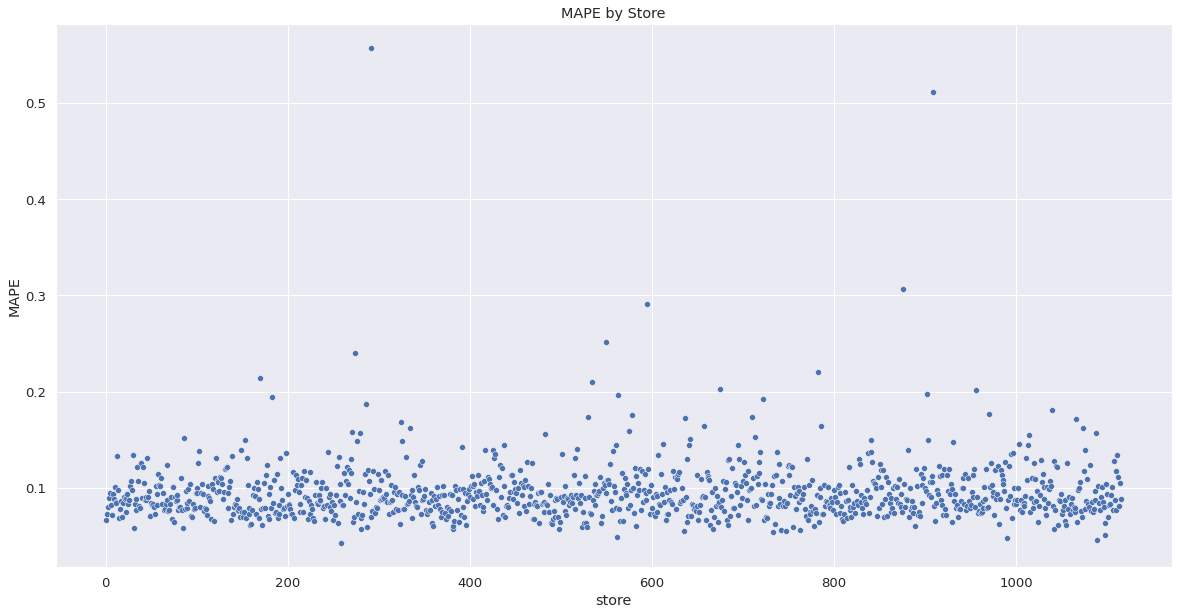

In [79]:
sns.scatterplot(x='store', y='MAPE', data=df92 ).set_title('MAPE by Store')

## 9.2. TOTAL PERFORMANCE

In [80]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,832,960.00"
1,worst_scenario,"R$283,102,898.04"
2,best_scenario,"R$284,563,051.71"


## 9.3. MACHINE LEARNING PERFORMANCE

In [81]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

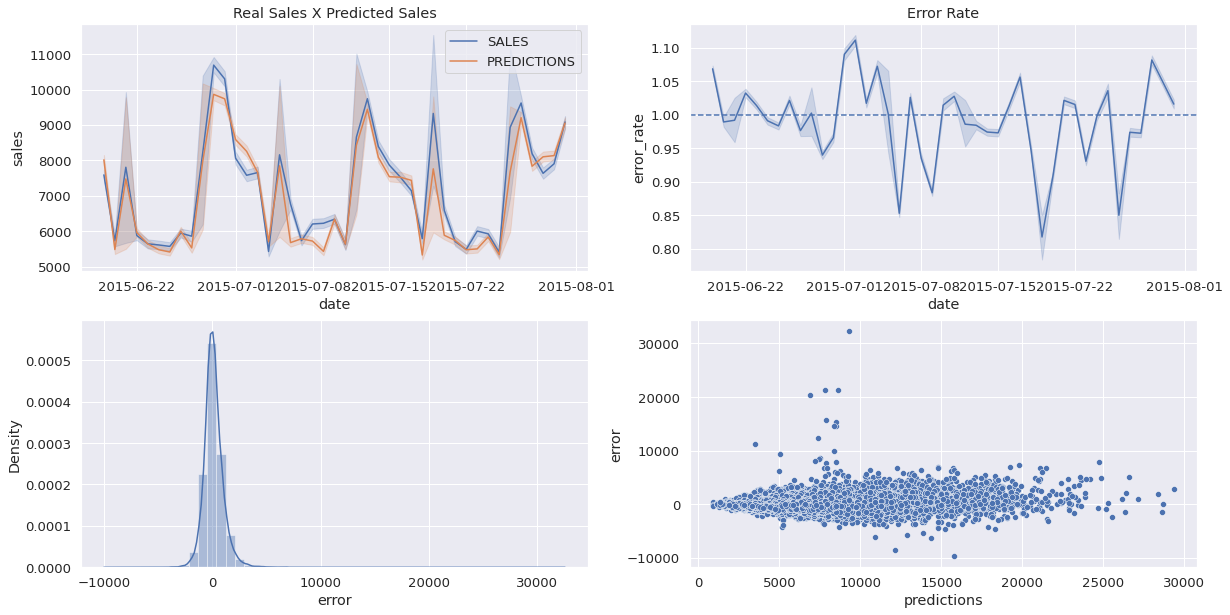

In [82]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS').set_title('Real Sales X Predicted Sales')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 ).set_title('Error Rate')
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. DEPLOY MODEL TO PRODUCTION

In [83]:
pickle.dump( model_xgb_tuned, open( '/home/kazu/Repos/Rossmann_Sales_Prediction/model/model_rossmann.pkl', 'wb') )

## 10.1. Rossman Class

In [84]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__(self):
        self.home_path='/home/kazu/Repos/Rossmann_Sales_Prediction/'
        self.competition_discante_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ) )
        
   
    def data_cleaning( self, df1 ):

        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',11: 'Nov',12: 'Dec'}
        df1['promo_interval'].fillna( 0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
   
    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week_of_year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year_week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition_since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

        # 3.0. VARIABLE FILTRATION
        ## 3.1. Rows Filter
        df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection
        cols_drop = ['open', 'promo_interval', 'month_map'] 
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
   
    def data_preparation(self, df5 ):
        ## 5.2. Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        # competitions_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values ) 
        
        ### 5.3.1. Encoding
        # state_holiday - One hot encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encodin
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week','promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos','month_sin',
                         'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']       
        
        return df5[cols_selected] 
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [85]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/kazu/Repos/Rossmann_Sales_Prediction/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [104]:
import requests

In [105]:
# Loading test dataset
df10 = pd.read_csv( '/home/kazu/Repos/Rossmann_Sales_Prediction/Data/test.csv' )

In [106]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [32, 12, 22, 43] ) ] 

# remove closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [107]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [109]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-predict.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [110]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [102]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction']))

Store Number 12 will sell R$195,032.23 in the next 6 weeks
Store Number 22 will sell R$171,019.43 in the next 6 weeks
Store Number 32 will sell R$190,117.78 in the next 6 weeks
Store Number 43 will sell R$243,480.95 in the next 6 weeks


In [103]:
d2

,store,prediction
0,12,195032.23
1,22,171019.43
2,32,190117.78
3,43,243480.95
